## EDA and Report Generation

### Vegas Accuracy
Here we will look at Vegas bookmakers historical performance predicting the NFL games.

In [2]:
import pandas as pd
from pathlib import Path
from src.config import INTERIM_DATA_DIR, RAW_DATA_DIR
from sklearn.model_selection import train_test_split
import re

train_path: Path = INTERIM_DATA_DIR / "trainset.csv"
base_path: Path = INTERIM_DATA_DIR / "base.csv"

df_base = pd.read_csv(str(base_path))
df_base.head()

,id,season,event_date,tm_nano,tm_market,tm_name,tm_alias,opp_nano,opp_market,opp_name,...,opp_rush_tds,opp_rush_yds,opp_third_down_att,opp_third_down_conv,opp_third_down_conv_pct,opp_time_of_possession,opp_times_sacked,opp_total_yds,opp_turnovers,opp_yds_sacked_for
0,200009030min,2000,2000-09-03,AzOs5UWsXusSW,Minnesota,Vikings,MIN,1vVmWGzUZ1rea,Chicago,Bears,...,1,153,15,9,0.600,1954,2,425,1,18
1,200009030kan,2000,2000-09-03,oiGiwWPf0UqMC,Kansas City,Chiefs,KC,LJmHetie5VbbO,Indianapolis,Colts,...,1,119,13,6,0.462,1993,1,386,2,6
2,200009030was,2000,2000-09-03,9JtBk8kFeaGEs,Washington,Football Team,WAS,jJBGuksuDJF5L,Carolina,Panthers,...,0,112,11,2,0.182,1606,6,236,1,59
3,200009030atl,2000,2000-09-03,mLspw4gJNTQGN,Atlanta,Falcons,ATL,IwSI92ZDKoazn,San Francisco,49ers,...,1,92,9,2,0.222,1701,1,339,1,6
4,200009030cle,2000,2000-09-03,IR4gIYmh269EI,Cleveland,Browns,CLE,RtOjnciWkJPaL,Jacksonville,Jaguars,...,2,119,16,10,0.625,2223,4,398,0,22


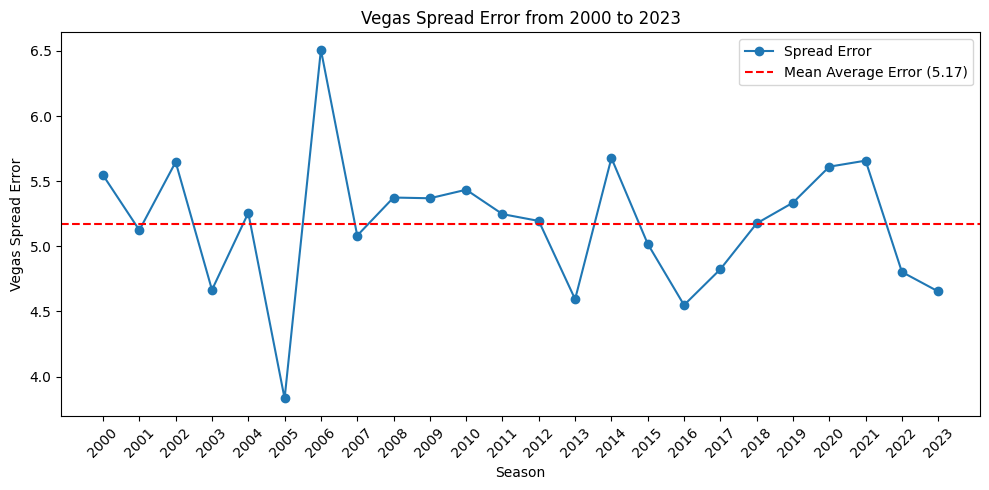

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from src.config import FIGURES_DIR

#error scenarios 
#if tm_spread -ve and r_spread > tm_spread
#if tm_spread +ve and  r_spread < tm_spread
def calc_vegas_error(r: pd.Series):
    r_spread = r.loc['tm_score'] - r.loc['opp_score']
    tm_spread = r.loc['tm_spread']
    if tm_spread <= 0.:
        r['vegas_error'] = max(0, abs(tm_spread) - r_spread)
    else:
        r['vegas_error'] = max(0, tm_spread + r_spread)
    return r

df_base = df_base.apply(calc_vegas_error, axis=1)
df_vegas_avg = df_base.loc[:, ['season','vegas_error']].set_index('season')
vegas_avg_err = []
for season in range(2000, 2024):
    vegas_avg_err.append(df_vegas_avg.loc[season, 'vegas_error'].mean())

overall_avg = np.mean(vegas_avg_err)
# Plot the spread error for each season
seasons = range(2000, 2024)
plt.figure(figsize=(10,5))
plt.plot(seasons, vegas_avg_err, marker='o', label='Spread Error')

# Plot the overall average line
plt.axhline(y=overall_avg, color='r', linestyle='--', label=f'Mean Average Error ({overall_avg:.2f})')

# Customize the x-axis to display every season
plt.xticks(seasons, rotation = 45)  # Rotating labels for better readability

plt.xlabel('Season')
plt.ylabel('Vegas Spread Error')
plt.title('Vegas Spread Error from 2000 to 2023')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent label overlap
fig_path = FIGURES_DIR / "vegas_spread_error.png"
plt.savefig(str(fig_path))
plt.show()


In [6]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from src.config import PROCESSED_DATA_DIR, FIGURES_DIR
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

input_test_path: Path = PROCESSED_DATA_DIR / "testset.csv"
input_train_path: Path = PROCESSED_DATA_DIR / "trainset.csv"

df_test = pd.read_csv(str(input_test_path), index_col='id')
df_train = pd.read_csv(str(input_train_path), index_col='id')

X_train, y_train = df_train.drop(columns=['r_spread']), df_train['r_spread']
X_test, y_test = df_test.drop(columns=['r_spread']), df_test['r_spread']

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

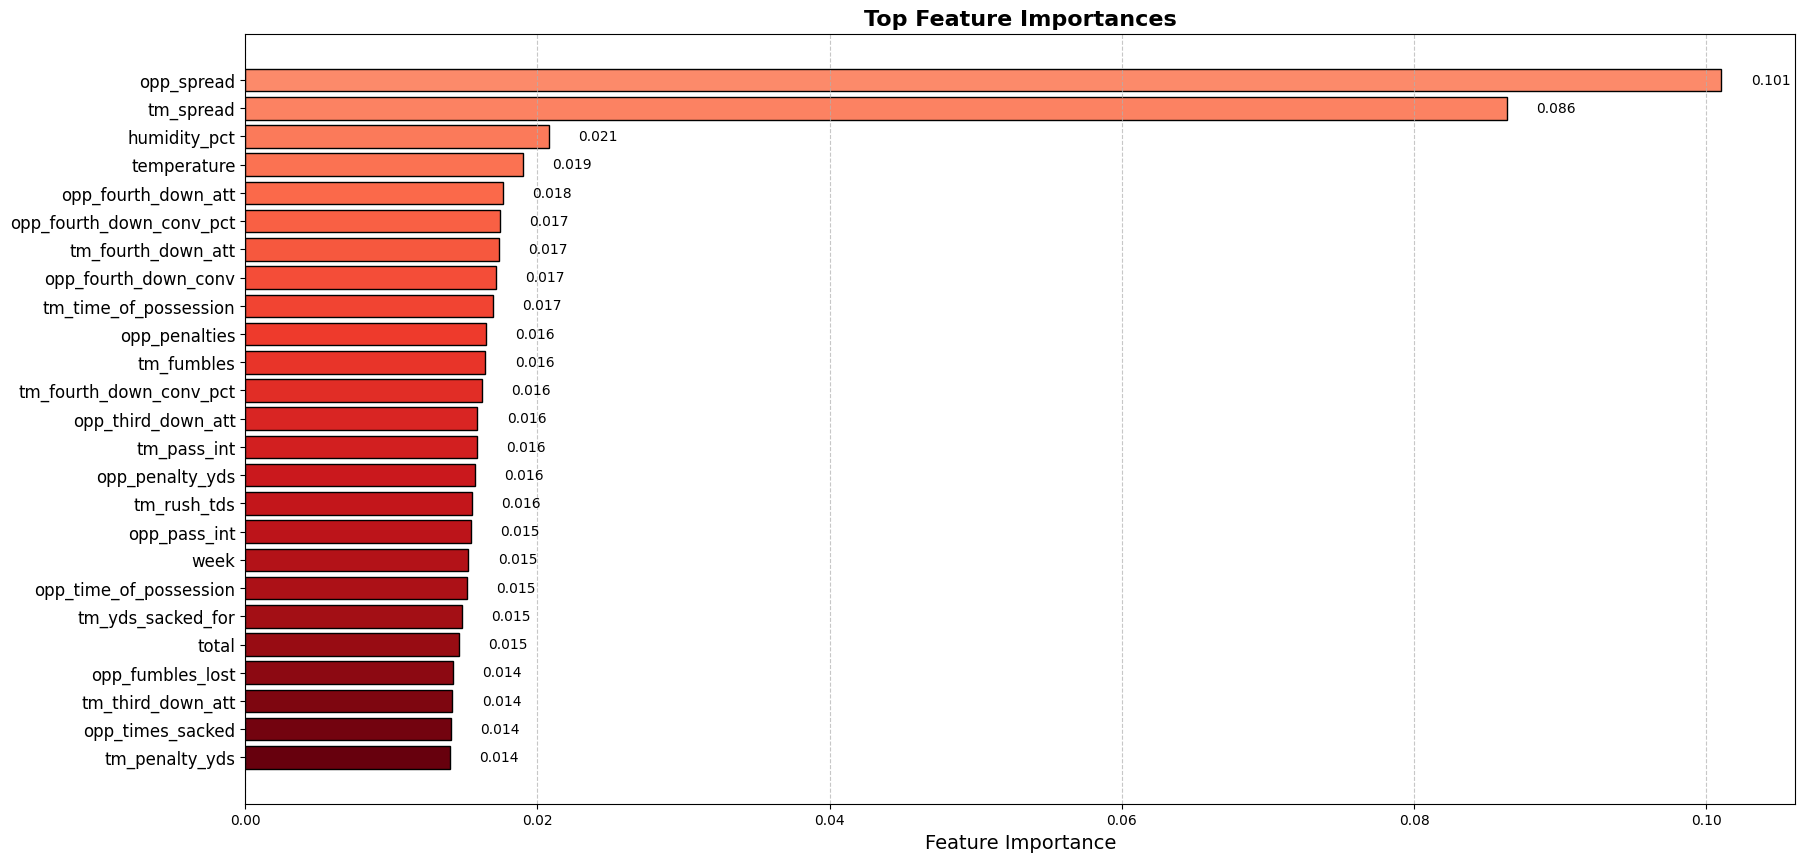

In [20]:
# Get feature importances and sort them in descending order
feature_importances = rf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]  # Descending order

# Fetch the corresponding feature labels for the top N features
top_n = 25  # Adjust as needed
top_features = sorted_idx[:top_n]
top_feature_names = X_train.columns[top_features]  # Get feature names
top_importances = feature_importances[top_features]

# Create a color gradient from light to dark blue
colors = plt.cm.Reds(np.linspace(0.4, 1, top_n))

# Create the plot
plt.figure(figsize=(20, 10))
bars = plt.barh(range(top_n), top_importances, align='center', color=colors, edgecolor='black')

# Set feature names as y-axis labels
plt.yticks(range(top_n), top_feature_names, fontsize=12)
plt.gca().invert_yaxis()  # Ensure the most important feature is on top

# Add title and labels with better fonts
plt.title('Top Feature Importances', fontsize=16, fontweight='bold')
plt.xlabel('Feature Importance', fontsize=14)

# Add value labels next to the bars for clarity
for bar, importance in zip(bars, top_importances):
    plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2, 
             f'{importance:.3f}', va='center', ha='left', fontsize=10, color='black')

# Add gridlines for easier reading
plt.grid(axis='x', linestyle='--', alpha=0.7)


fig_path = FIGURES_DIR / "top_feature_importances.png"
plt.savefig(str(fig_path))
plt.show()

